# Classification and Localization model

This notebook is based on the Deep Learning course from the Master Datascience Paris Saclay. Materials of the course can be found [here](https://github.com/m2dsupsdlclass/lectures-labs).

**Goals**
* Build and train a classification and localisation network.
* Showcase the flexibility of neural network with several, heterogenous outputs (bounding boxes and classes).

**Dataset**
* PASCAL VOC 2012 from [Kaggle](https://www.kaggle.com/huanghanchina/pascal-voc-2012)

We will build the model in three consecutive steps:
* **Extract label annotations** from a standard Object Detection dataset, namely **PASCAL VOC 2012**.
* Use a pre-trained image classification model (namely ResNet50) to **precompute convolutional representations** with shape $(7, 7, 2048)$ for all the images in the object detection training set.
* **Design and train a baseline object detection model with two heads** to predict:
    - class labels
    - bounding box coordinates of a single detected object in the image
    
Note that the simple baseline model presented here will only detect a single occurence of a class per image. More work would be required to detect all possible object occurences in the images. Take a look at the [slides](https://m2dsupsdlclass.github.io/lectures-labs/slides/05_conv_nets_2/index.html#1) for references to states of the art object detection models such as [Faster RCNN](https://arxiv.org/abs/1506.01497) and [YOLO9000](https://arxiv.org/abs/1612.08242).

In [1]:
# Load packages
import h5py
import os

import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as etree

from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.layers import Convolution2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, Input
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.models import Model

## Loading images and annotations

We will be using PASCAL VOC 2012, a dataset widely used in detection and segmentation [link](http://host.robots.ox.ac.uk/pascal/VOC/). To lower memory footprint and training time, we will only use five classes: *dog*, *cat*, *bus*, *car*, *aeroplane*. Here are the first steps:
* Load the annotations file from PASCAL VOC and parse it (xml files)
* Keep only the annotations we are interested in, and containing a single object
* Pre-compute ResNet conv5c from the corresponding images

In [2]:
# Parse the xml annotation file and retrieve the path to each image, its size and annotations
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    fname = z.find('./filename').text
    dicts = [{obj.find('name').text: [int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))]}
             for obj in objects]
    return {'size': size, 'filename': fname, 'objects': dicts}

In [3]:
# Filters annotations keeping only those we are interested in.
# We only keep images in which there is a single item
annotations = []

filters = ['dog', 'cat', 'bird', 'cow', 'horse']
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

ANNOTATION_DIR = 'VOC2012/Annotations/'
for filename in sorted(os.listdir(ANNOTATION_DIR)):
    annotation = extract_xml_annotation(os.path.join(ANNOTATION_DIR, filename))
    
    new_objects = []
    for obj in annotation['objects']:
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)
    
    if len(new_objects) == 1:
        annotation['class'] = list(new_objects[0].keys())[0]
        annotation['bbox'] = list(new_objects[0].values())[0]
        annotation.pop('objects')
        annotations.append(annotation)

In [4]:
print(f'Number of images with annotations: {len(annotations)}.')

Number of images with annotations: 3179.


In [5]:
print(f'Example contents of one annotation: {annotations[0]}')

Example contents of one annotation: {'size': (500, 375), 'filename': '2007_000063.jpg', 'class': 'dog', 'bbox': [123, 115, 379, 275]}


In [6]:
print(f'Correspondence between indices and labels: {idx2labels}')

Correspondence between indices and labels: {0: 'dog', 1: 'cat', 2: 'bird', 3: 'cow', 4: 'horse'}


## Pre-computing representations

Before designing the object detection model itself, we will pre-process all the dataset to project the images as spatial maps in a $(7, 7, 2048)$ dimensional space once and for all. The goal is to avoid repeateadly processing the data from the original images when training the top layers of the detection network.

Let's load a headless pre-trained `ResNet50` model from Keras and all the layers after the `AveragePooling2D` layer (included).

In [7]:
model = ResNet50(include_top=False, weights="imagenet")
input_tensor = model.layers[0].input
output_tensor = model.layers[-2].output
model_conv = Model(input_tensor, output_tensor)

## Predicting on a batch of images

The `predict_batch` function is defined as follows:
* open each image, and resize then to `img_size`
* stack them as a batch tensor of shape `(batch, img_size_x, img_size_y, 3)`
* pre-process the batch and make a forward pass with the model

In [8]:
def predict_batch(model, img_batch_path, img_size=None):
    img_list = []
    
    for im_path in img_batch_path:
        img = imread(im_path)
        if img_size:
            img = resize(img, img_size,
                         mode='reflect',
                         preserve_range=True)
            
        img = img.astype('float32')
        img_list.append(img)
    
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError('''When both img_size and crop_size are None, all images
            in image_paths must have the same shapes.''')
    
    return model(preprocess_input(img_batch)).numpy()

In [10]:
# Test the model
IMG_DIR = 'VOC2012/JPEGImages/'
IMG_PATH = os.path.join(IMG_DIR, annotations[0]['filename'])
output = predict_batch(model_conv, [IMG_PATH], (1000, 224))
print(f'Shape of the output: {output.shape}')

Shape of the output: (1, 32, 7, 2048)


The output size is given by `(batch_size, 1000/32 = 32, 224/32 = 7, 2048)`.

## Compute representations on all images in our annotations

In [11]:
def compute_representations(annotations):
    batch_size = 32
    batches = []
    
    n_batches = len(annotations) // 32 + 1
    for batch_idx in range(n_batches):
        batch_bgn = batch_idx * 32
        batch_end = min(len(annotations), (batch_idx + 1) * 32)
        img_names = []
        for annotation in annotations[batch_bgn:batch_end]:
            img_path = os.path.join(IMG_DIR, annotation['filename'])
            img_names.append(img_path)
        batch = predict_batch(model_conv, img_names, img_size=(224, 224))
        batches.append(batch)
        print(f'Batch {batch_idx + 1}/{n_batches} prepared')
    return np.vstack(batches)

In [12]:
%%time
reprs = compute_representations(annotations)

Batch 1/100 prepared
Batch 2/100 prepared
Batch 3/100 prepared
Batch 4/100 prepared
Batch 5/100 prepared
Batch 6/100 prepared
Batch 7/100 prepared
Batch 8/100 prepared
Batch 9/100 prepared
Batch 10/100 prepared
Batch 11/100 prepared
Batch 12/100 prepared
Batch 13/100 prepared
Batch 14/100 prepared
Batch 15/100 prepared
Batch 16/100 prepared
Batch 17/100 prepared
Batch 18/100 prepared
Batch 19/100 prepared
Batch 20/100 prepared
Batch 21/100 prepared
Batch 22/100 prepared
Batch 23/100 prepared
Batch 24/100 prepared
Batch 25/100 prepared
Batch 26/100 prepared
Batch 27/100 prepared
Batch 28/100 prepared
Batch 29/100 prepared
Batch 30/100 prepared
Batch 31/100 prepared
Batch 32/100 prepared
Batch 33/100 prepared
Batch 34/100 prepared
Batch 35/100 prepared
Batch 36/100 prepared
Batch 37/100 prepared
Batch 38/100 prepared
Batch 39/100 prepared
Batch 40/100 prepared
Batch 41/100 prepared
Batch 42/100 prepared
Batch 43/100 prepared
Batch 44/100 prepared
Batch 45/100 prepared
Batch 46/100 prepar

In [12]:
# Serialize representations
#h5f = h5py.File('voc_representations.h5', 'w')
#h5f.create_dataset('reprs', data=reprs)
#h5f.close()

## Building ground truth from annotation

We cannot use directly the annotation dictionnary as ground truth in our model. We will build the `y_true` tensor that will be compared to the output of the model.

**Boxes coordinates**
* THe image is resized to a fixed $224\times 224$ to be fed to the usual `ResNet50` input, the boxes coordinates of the annotations need to be resized accordingly.
* We have to convert the top-left and bottom-right coordinates $(x_{min}, y_{min}, x_{max}, y_{max})$ to center, height, width $(x_{c}, y_{c}, w, h)$.

**Classes labels**
* The class labels are mapped to correspondings indexes.

In [13]:
img_resize = 224
num_classes = len(labels2idx.keys())

def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = np.zeros((num_classes))
        cls_idx = labels2idx[annotation['class']]
        cls[cls_idx] = 1.0
        
        coords = annotation['bbox']
        size = annotation['size']
        
        # Resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1],
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])
        
        # Compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)
    
    # Stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)

In [14]:
classes, boxes = tensorize_ground_truth(annotations)

In [15]:
print(f'Classes shape: {classes.shape}, Boxes shape: {boxes.shape}')

Classes shape: (3179, 5), Boxes shape: (3179, 4)


## Interpreting output of model

Interpreting the output of the model is going from the output tensors to a set of classes (with confidences) and boxes corrdinates. It corresponds to reverting the previous preocess.

In [16]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]
    
    small_box = [max(0, cx - w / 2), max(0, cy - h / 2),
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize),
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize),
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {'class': classname, 'confidence': confidence, 'bbox': fullsize_box}
    return output

Check the classes and boxes tensors of some known annotations.

In [17]:
print(f'Original annotation:\n {annotations[0]}')
print(f'Interpreted output:\n {interpret_output(classes[0], boxes[0], img_size=annotations[0]["size"])}')

Original annotation:
 {'size': (500, 375), 'filename': '2007_000063.jpg', 'class': 'dog', 'bbox': [123, 115, 379, 275]}
Interpreted output:
 {'class': 'dog', 'confidence': 1.0, 'bbox': [123, 114, 379, 275]}


## Intersection over Union

In order to assess the quality of our model, we will monitor the IoU between ground trith box and predicted box. The following function computes the IoU.

In [18]:
def IoU(boxA, boxB):
    # Find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])
    
    # Compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0)
    
    # Compute the area of each box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas minus the intersection areas
    return inter_area / float(boxA_area + boxB_area - inter_area)

Check the IoU of the bounding box of the original annotation with the bounding box of the interpretation of the resized version of the same annotation is close to $1.0$.

In [19]:
original = annotations[0]
interpreted = interpret_output(classes[0], boxes[0], img_size=annotations[0]["size"])
print(f'IoU of the original versus the interpreted bounding box: {IoU(original["bbox"], interpreted["bbox"])}.')

IoU of the original versus the interpreted bounding box: 0.9937888198757764.


In [20]:
def plot_IoU(boxA, boxB, img_size=(10, 10)):
    """Plot the IoU measure
    """
    iou = IoU(boxA, boxB)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_ylim(0, img_size[1])
    ax.set_xlim(0, img_size[0])
    ax.add_patch(plt.Rectangle((boxA[0], boxA[1]),
                               boxA[2] - boxA[0],
                               boxA[3] - boxA[1],
                               color='blue', alpha=0.5))
    ax.add_patch(plt.Rectangle((boxB[0], boxB[1]),
                               boxB[2] - boxB[0],
                               boxB[3] - boxB[1],
                               color='red', alpha=0.5))
    ax.set_title(f'IoU: {iou}')
    return fig, ax

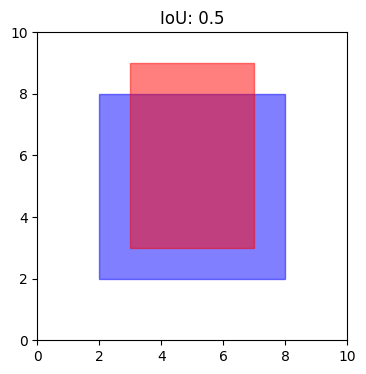

In [21]:
fix, ax = plot_IoU([2, 2, 8, 8], [3, 3, 7, 9])
plt.show()

## Classification and Localisation model

We build a two headed model for classification and localisation.

In [22]:
def classif_local_stupid_model(num_classes):
    """Stupid model that averages all the spatial information
    
    The goal of this model is to show that it's a very bad idea to destroy
    the spatial information with GlobalAveragePooling2D layer if our
    goal is to do object localization.
    """
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    x = Dense(1000)(x)
    head_classes = Dense(num_classes, activation='softmax', name='head_classes')(x)
    head_boxes = Dense(4, name='head_boxes')(x)
    
    model = Model(inputs=model_input, outputs=[head_classes, head_boxes], name='resnet_loc')
    model.compile(optimizer='adam', loss=[categorical_crossentropy, mean_squared_error], 
                  loss_weights=[1., 0.01])
    return model

In [23]:
model = classif_local_stupid_model(num_classes)

Let's debug the model: select only a few examples and test the model before training with random weights.

In [24]:
num = 64
inputs = reprs[0:num]
out_cls, out_boxes = classes[0:num], boxes[0:num]

print(f'Input batch shape: {inputs.shape}')
print(f'Ground truth batch shapes: {out_cls.shape} and {out_boxes.shape}')

Input batch shape: (64, 7, 7, 2048)
Ground truth batch shapes: (64, 5) and (64, 4)


In [25]:
out = model.predict(inputs)
print(f'Output model batch shapes: {out[0].shape} and {out[1].shape}')

2/2 [==============================] - 1s 9ms/step
Output model batch shapes: (64, 5) and (64, 4)


Now, check whether the loss decreases and eventually if we are able to overfit on these few examples for debugging purpose.

In [26]:
history = model.fit(inputs, [out_cls, out_boxes], batch_size=10, epochs=10)

Epoch 1/10
7/7 [==============================] - 2s 42ms/step - loss: 74.0859 - head_classes_loss: 17.0199 - head_boxes_loss: 5706.5991
Epoch 2/10
7/7 [==============================] - 0s 45ms/step - loss: 44.1928 - head_classes_loss: 11.3489 - head_boxes_loss: 3284.3928
Epoch 3/10
7/7 [==============================] - 0s 42ms/step - loss: 26.5670 - head_classes_loss: 2.7161 - head_boxes_loss: 2385.0896
Epoch 4/10
7/7 [==============================] - 0s 40ms/step - loss: 16.5942 - head_classes_loss: 1.6508 - head_boxes_loss: 1494.3428
Epoch 5/10
7/7 [==============================] - 0s 47ms/step - loss: 13.8967 - head_classes_loss: 0.2897 - head_boxes_loss: 1360.6948
Epoch 6/10
7/7 [==============================] - 0s 47ms/step - loss: 10.5557 - head_classes_loss: 0.2433 - head_boxes_loss: 1031.2345
Epoch 7/10
7/7 [==============================] - 0s 41ms/step - loss: 8.0205 - head_classes_loss: 0.2529 - head_boxes_loss: 776.7578
Epoch 8/10
7/7 [==============================] 

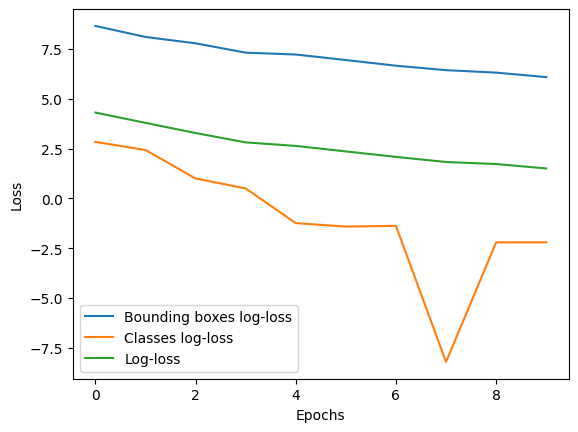

In [27]:
plt.plot(np.log(history.history["head_boxes_loss"]), label="Bounding boxes log-loss")
plt.plot(np.log(history.history["head_classes_loss"]), label="Classes log-loss")
plt.plot(np.log(history.history["loss"]), label="Log-loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Displaying images and bounding box

In order to display our annotations, we build the function `plot_annotations` as follows:
* display the image
* display on top annotations and ground truth bounding boxes and classes

The `display` function:
* takes a single index and computes the result of the model
* interpret the ouput of the model as a bounding box
* calls the `plot_annotations` function

In [28]:
def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2] - bbox[0] + 1, bbox[3] - bbox[1] + 1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, color='white', bbox={'facecolor':color, 'alpha':0.5})
    
def plot_annotations(img_path, annotation=None, ground_truth=None):
    img = imread(img_path)
    plt.imshow(img)
    current_axis = plt.gca()
    if ground_truth:
        text = "GT " + ground_truth["class"]
        patch(current_axis, ground_truth["bbox"], text, "red")
    if annotation:
        conf = f'{annotation["confidence"]:0.2f} '
        text = conf + annotation["class"]
        patch(current_axis, annotation["bbox"], text, "blue")
    plt.axis('off')

def display(model, index, ground_truth=True):
    res = model.predict(reprs[index][np.newaxis])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations(IMG_DIR + annotations[index]["filename"], 
                     output, annotations[index] if ground_truth else None)

Let's display the predictions of the model and the ground truth annotation for a couple of images in our tiny debugging training set. The class should be right but the localization has little chance to be correct. The model has even more trouble on images that were not part of our tiny debugging training set.

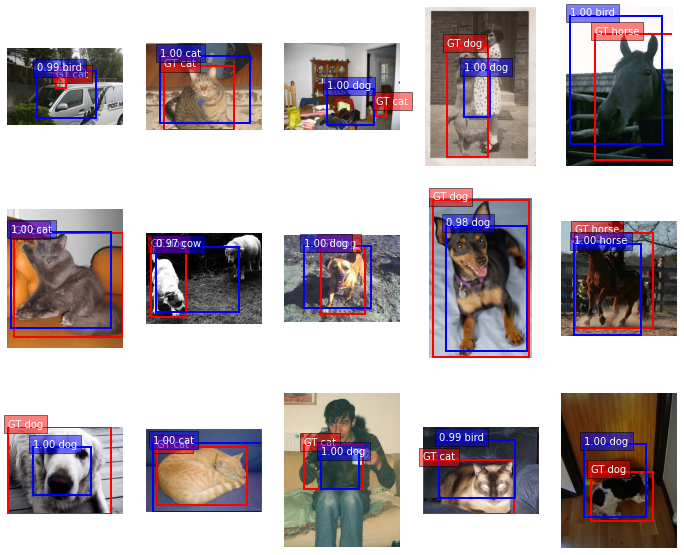

In [29]:
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()

## Computing accuracy

For each example `(class_true, bbox_true)`, we consider it positive if and only if:
* the argmax of `output_class` of the model is `class_true`
* the IoU between the `output_bbox` and the `bbox_true` is above a threshold (usually $0.5$)

The accuracy of a model is then the number of positive divided be the total number. The following functions compute the class accuracy, IoU average and global accuracy.

In [30]:
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = IoU(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [31]:
def compute_acc(model, train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "Train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations) 
        split_name = "Test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)
    
    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)
    
    print(f'{split_name} acc: {acc:0.3f}, mean IoU: {iou:0.3f}, acc_valid: {valid:0.3f}')

In [32]:
compute_acc(model, train=True)
compute_acc(model, train=False)

Train acc: 0.681, mean IoU: 0.460, acc_valid: 0.330
Test acc: 0.654, mean IoU: 0.382, acc_valid: 0.204


## Training on the whole dataset

We split out dataset into a train and a test dataset. Then, train the model on the whole training set.

In [33]:
# Keep last examples for test
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
test_inputs = reprs[train_num:]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print(f'Length of the train set: {train_num}, length of the test set: {test_num}')

Length of the train set: 2862, length of the test set: 317


In [34]:
model = classif_local_stupid_model(num_classes)

In [35]:
batch_size = 32
inputs = reprs[0:train_num]
out_cls, out_boxes = classes[0:train_num], boxes[0:train_num]

history = model.fit(inputs, y=[out_cls, out_boxes],
                    validation_data=(test_inputs, [test_cls, test_boxes]),
                    batch_size=batch_size, epochs=20, verbose=2)

Train on 2862 samples, validate on 317 samples
Epoch 1/20
2862/2862 - 2s - loss: 23.1427 - head_classes_loss: 4.2913 - head_boxes_loss: 1881.5513 - val_loss: 11.6634 - val_head_classes_loss: 2.3376 - val_head_boxes_loss: 932.2500
Epoch 2/20
2862/2862 - 1s - loss: 10.0735 - head_classes_loss: 1.3344 - head_boxes_loss: 871.9286 - val_loss: 10.3703 - val_head_classes_loss: 2.1319 - val_head_boxes_loss: 824.4774
Epoch 3/20
2862/2862 - 1s - loss: 8.9163 - head_classes_loss: 1.2700 - head_boxes_loss: 762.6355 - val_loss: 9.2090 - val_head_classes_loss: 1.7534 - val_head_boxes_loss: 745.9510
Epoch 4/20
2862/2862 - 1s - loss: 8.5780 - head_classes_loss: 1.2523 - head_boxes_loss: 734.7751 - val_loss: 9.8123 - val_head_classes_loss: 2.0455 - val_head_boxes_loss: 775.7838
Epoch 5/20
2862/2862 - 1s - loss: 8.0337 - head_classes_loss: 0.8526 - head_boxes_loss: 719.1849 - val_loss: 11.7608 - val_head_classes_loss: 4.4182 - val_head_boxes_loss: 733.9536
Epoch 6/20
2862/2862 - 1s - loss: 8.2008 - head

In [36]:
compute_acc(model, train=True)
compute_acc(model, train=False)

Train acc: 0.974, mean IoU: 0.586, acc_valid: 0.690
Test acc: 0.836, mean IoU: 0.439, acc_valid: 0.374


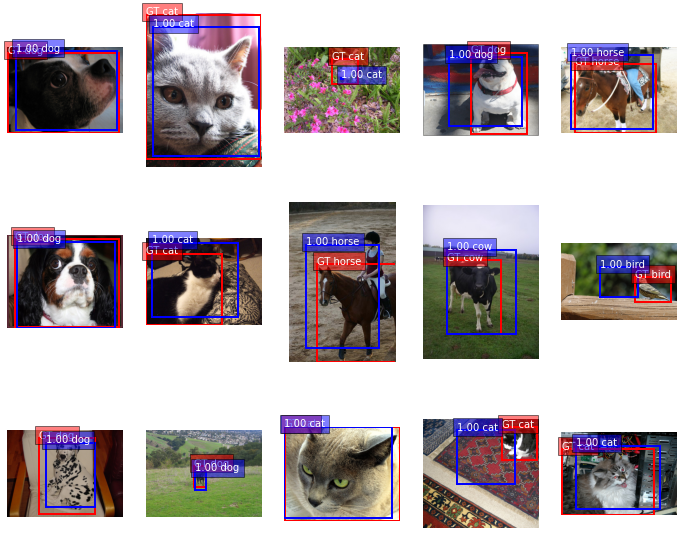

In [37]:
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()

## Build a better model

In [38]:
def classif_local_model(num_classes):
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    x = Dense(1000)(x)
    head_classes = Dense(num_classes, activation='softmax', name='head_classes')(x)
    
    y = Convolution2D(4, (1, 1), activation='relu', name='hidden_conv')(model_input)
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    head_boxes = Dense(4, name='head_boxes')(y)
    
    model = Model(inputs=model_input, outputs=[head_classes, head_boxes], name='resnet_loc')
    model.compile(optimizer='adam', loss=[categorical_crossentropy, 'mse'], loss_weights=[1., 1 / (224 * 224)])
    return model

In [39]:
model = classif_local_model(num_classes)

In [40]:
history = model.fit(inputs, y=[out_cls, out_boxes],
                    validation_data=(test_inputs, [test_cls, test_boxes]),
                    batch_size=batch_size, epochs=20, verbose=2)

Train on 2862 samples, validate on 317 samples
Epoch 1/20
2862/2862 - 3s - loss: 5.9966 - head_classes_loss: 5.8897 - head_boxes_loss: 4641.7891 - val_loss: 2.8450 - val_head_classes_loss: 2.8086 - val_head_boxes_loss: 1649.5681
Epoch 2/20
2862/2862 - 2s - loss: 1.2390 - head_classes_loss: 1.2067 - head_boxes_loss: 1604.0959 - val_loss: 2.1319 - val_head_classes_loss: 2.1155 - val_head_boxes_loss: 1173.9926
Epoch 3/20
2862/2862 - 2s - loss: 1.1972 - head_classes_loss: 1.1672 - head_boxes_loss: 1147.6346 - val_loss: 2.4294 - val_head_classes_loss: 2.4094 - val_head_boxes_loss: 969.9738
Epoch 4/20
2862/2862 - 2s - loss: 0.8497 - head_classes_loss: 0.8244 - head_boxes_loss: 1013.7648 - val_loss: 3.1588 - val_head_classes_loss: 3.1394 - val_head_boxes_loss: 882.0372
Epoch 5/20
2862/2862 - 2s - loss: 0.8631 - head_classes_loss: 0.8424 - head_boxes_loss: 920.1373 - val_loss: 2.1792 - val_head_classes_loss: 2.1726 - val_head_boxes_loss: 852.3141
Epoch 6/20
2862/2862 - 2s - loss: 0.6468 - head

In [41]:
compute_acc(model, train=True)
compute_acc(model, train=False)

Train acc: 0.973, mean IoU: 0.635, acc_valid: 0.769
Test acc: 0.852, mean IoU: 0.457, acc_valid: 0.399


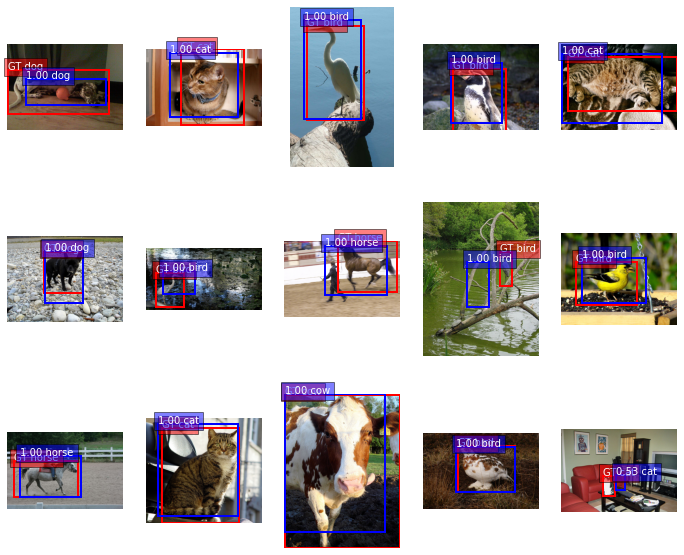

In [42]:
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()